# interrupting and continuing of a simulation

In [5]:
from crpropa import * 
import numpy as np 
import matplotlib.pyplot
import os 
from multiprocessing import cpu_count

## example simulation


We test the interruption on the propagation of a spectrum with $E^{-1}$ from a distance of 1 Gpc with 1e7 particles. 




In [2]:
# create candidate vector with increasing energies
lg_E_min = 17
lg_E_max = 21
lgE = np.random.uniform(lg_E_min, lg_E_max, 100_000)
lgE.sort()

In [3]:
def init_candidate_vector():
    """ initilize the candidate vector. Has to be done before every simulation. """
    cv = CandidateVector()
    for i, _e in enumerate(lgE): 
        c = Candidate(i, 10**_e * eV, Vector3d(1 * Gpc, 0, 0), Vector3d(-1, 0, 0)) 
        cv.push_back(CandidateRefPtr(c))
    return cv

### full simulation

In [31]:
# general setup 
def get_sim(filename):
    """ returns a modulelist to ensure running the same modules in each case """
    
    sim = ModuleList() 
    sim.add(SimplePropagation(1 * kpc, 10 * kpc)) # choose small steps to ensure long simulations 

    obs = Observer() 
    obs.add(Observer1D())
    out = TextOutput(filename) 
    obs.onDetection(out) 
    sim.add(obs)

    sim.setShowProgress(True)
    return sim, out

os.makedirs("cand_vector", exist_ok=True)
sim, out = get_sim("cand_vector/full.txt") 
cv = init_candidate_vector()
sim.run(cv)
out.close()

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Wed Sep  4 16:28:28 2024 : [ Finished ] 100%    Needed: 00:00:55  - Finished at Wed Sep  4 16:29:23 2024


### simulation with interruption

In [32]:
sim, out = get_sim("cand_vector/interrupted.txt")

out_interrupt = TextOutput("cand_vector/on_interruption.txt")
sim.setInterruptAction(out_interrupt)

sim.setShowProgress(True) 
cv = init_candidate_vector()
sim.run(cv)

crpropa::ModuleList: Number of Threads: 12
Run ModuleList


crpropa::ModuleList: Signal 2 (SIGINT/SIGTERM) received
############################################################################
#	Interrupted CRPropa simulation 
# in total 56959 Candidates have not been started.
# the indicies of the vector haven been written to to output file. 
############################################################################


KeyboardInterrupt: 

In [33]:
out.close()

In [34]:
# load candidates from interrupted simulation 

file = "cand_vector/on_interruption.txt"
pc = ParticleCollector() 
pc.load(file)

# expected size of particles should be equal to the number of cores 
assert pc.size() <= cpu_count() , f"the number of loaded particles ({pc.size()}) must be lower or equal to the number of cores ({cpu_count()})"

# load indicies of not started candidates
with open(file, "r") as f: 
    line = f.readlines()[-1]
    indices = np.array(line.strip("\n").split("\t")[1:-1], dtype= int)

print("number of indices read from file:", len(indices))

number of indices read from file: 56959


In [35]:
# create a new candidate vector with the missing particles 
cv_new = pc.getContainer()
cv = init_candidate_vector()
for i, c in enumerate(cv): 
    if i in indices: 
        cv_new.push_back(c)
    

In [36]:
# run the simulation with the missing candidates 
sim, out = get_sim("cand_vector/continued.txt")
sim.run(cv_new)
out.close()

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Wed Sep  4 16:29:55 2024 : [ Finished ] 100%    Needed: 00:00:37  - Finished at Wed Sep  4 16:30:32 2024


# show the data from the different simulations

In [37]:
import pandas as pd 
import matplotlib.pyplot as plt 

def read_crp(filename): 
    """ read a crpropa output file """
    
    with open(filename) as f: 
        names = f.readline().strip("\n").split("\t")[1:]
    
    return pd.read_csv(filename, names = names, delimiter = "\t", comment="#")

In [38]:
df_full = read_crp("cand_vector/full.txt")
df_first_half = read_crp("cand_vector/interrupted.txt")
df_second_half = read_crp("cand_vector/continued.txt")

In [39]:
len(df_first_half), len(df_second_half)

(43030, 56970)

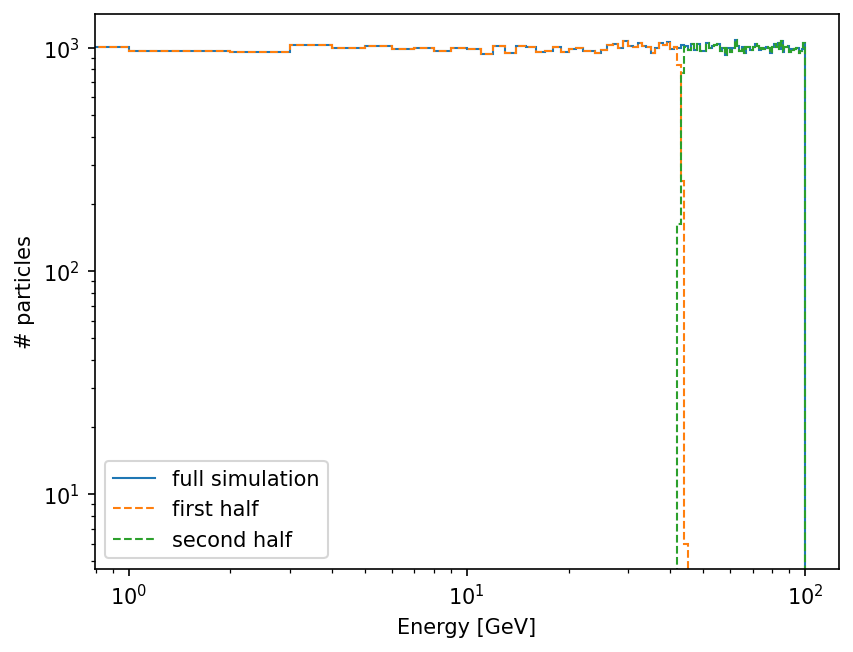

In [40]:
e_bins = np.logspace(-1, 3, 101) # in EeV as default output unit 
dE = np.diff(e_bins) 

dNdE_full = np.histogram(df_full.E, bins = e_bins)[0] 
dNdE_first = np.histogram(df_first_half.E, e_bins)[0] 
dNdE_second = np.histogram(df_second_half.E, e_bins)[0]
assert np.all(dNdE_full == (dNdE_first + dNdE_second))

plt.figure(dpi = 150) 
plt.stairs(dNdE_full, label = "full simulation")
plt.stairs(dNdE_first, label = "first half", ls = "--")
plt.stairs(dNdE_second, label = "second half", ls = "--")
plt.loglog()
plt.legend()
plt.ylabel("# particles")
plt.xlabel("Energy [GeV]")
plt.show()

# check ID number of particles

In [41]:
id_list_full = list(df_full.ID)
id_list_full.sort() 
assert np.all(id_list_full == np.arange(100_000))

In [42]:
id_list_continued = list(df_first_half.ID) + list(df_second_half.ID)
id_list_continued.sort() 
assert np.all(id_list_continued == np.arange(100_000))